In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import ColumnSelector

from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.backend import clear_session
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_PATH = os.path.abspath(os.path.join(os.getcwd(), '../'))

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

from server.ml_models.player_xgb import PlayerXGBData
from server.ml_models.betting_lasso import BettingLassoData
from server.ml_models.match_xgb import MatchXGBData

from src.model.metrics import regression_accuracy, measure_estimators
from src.model.charts import graph_yearly_model_performance, graph_tf_model_history

START_DATE = '1965-01-01'
DATA_KWARGS = {'train_years': (None, None), 'test_years': (None, None)}

np.random.seed(42)

In [2]:
data = [
    BettingLassoData(**DATA_KWARGS).data,
    PlayerXGBData(start_date=START_DATE, **DATA_KWARGS).data,
    MatchXGBData(**DATA_KWARGS).data,
]

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Returning data from 1965-01-01 to 2016-12-31

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finished getting afltables data

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/app/server/data_processors/feature_functions.py:524: FutureWarning: 'player_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(['player_id', 'year'], group_keys=True)
/app/server/data_processors/feature_functions.py:524: FutureWarning: 'year' is both an index level and a column label.
Defau

In [3]:
from functools import reduce

# Betting data starts in 2010, so fill it with 0s for seasons before that
betting_cols = data[0].columns
fillna_cols = {col: 0 for col in betting_cols}

def concat_data_frames(agg_data_frame, data_frame):
    if agg_data_frame is None:
        return data_frame

    agg_cols = set(agg_data_frame.columns)
    df_cols = set(data_frame.columns)
    drop_cols = agg_cols.intersection(df_cols)
    # Have to drop shared columns, and this seems a reasonable way of doing it without hard-coding values
    return pd.concat([agg_data_frame.drop(list(drop_cols), axis=1), data_frame], axis=1)

data_frame = reduce(concat_data_frames, data).fillna(fillna_cols).dropna()
# Could include match data going back to 1897, but only going back to 1965 will keep processing cost
# semi-reasonable for now
data_frame = data_frame.loc[(data_frame['year'] >= 1965) & (data_frame['year'] <= 2016)]
data_frame

win_odds  line_odds  oppo_win_odds  \
team             year round_number                                       
Adelaide         1991 2                 0.00        0.0           0.00   
                      3                 0.00        0.0           0.00   
                      4                 0.00        0.0           0.00   
                      5                 0.00        0.0           0.00   
                      6                 0.00        0.0           0.00   
                      7                 0.00        0.0           0.00   
                      9                 0.00        0.0           0.00   
                      10                0.00        0.0           0.00   
                      11                0.00        0.0           0.00   
                      12                0.00        0.0           0.00   
                      13                0.00        0.0           0.00   
                      14                0.00        0.0           0.00   
                      15                0.00        0.0           0.00   
                      16                0.00        0.0           0.00   
                      17                0.00        0.0           0.00   
                      18                0.00        0.0           0.00   
                      19                0.00        0.0           0.00   
                      20                0.00        0.0           0.00   
                      21                0.00        0.0           0.00   
                      22                0.00        0.0           0.00   
                      24                0.00        0.0           0.00   
                 1992 1                 0.00        0.0           0.00   
                      3                 0.00        0.0           0.00   
                      4                 0.00        0.0           0.00   
                      5                 0.00        0.0           0.00   
                      6                 0.00        0.0           0.00   
                      7                 0.00        0.0           0.00   
                      8                 0.00        0.0           0.00   
                      9                 0.00        0.0           0.00   
                      10                0.00        0.0           0.00   
...                                      ...        ...            ...   
Western Bulldogs 2015 21                3.60       23.5           1.31   
                      22                2.30        6.5           1.63   
                      23                1.22      -28.5           4.50   
                      24                0.00        0.0           0.00   
                 2016 1                 1.65       -7.5           2.25   
                      2                 1.25      -25.5           3.95   
                      3                 1.96        1.5           1.88   
                      4                 1.08      -49.5           8.00   
                      5                 1.13      -42.5           6.25   
                      6                 2.05        2.5           1.81   
                      7                 1.72       -4.5           2.15   
                      8                 1.42      -16.5           2.95   
                      9                 3.10       18.5           1.38   
                      10                1.48      -13.5           2.70   
                      11                1.73       -5.5           2.15   
                      12                2.20        5.5           1.70   
                      13                2.40        9.5           1.60   
                      15                3.15       16.5           1.38   
                      16                1.20      -33.5           4.80   
                      17                1.11      -43.5           7.00   
                      18                1.35      -20.5           3.25   
                      19                

In [4]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 16848 entries, (Adelaide, 1991, 2) to (Western Bulldogs, 2016, 27)
Data columns (total 77 columns):
win_odds                                           16848 non-null float64
line_odds                                          16848 non-null float64
oppo_win_odds                                      16848 non-null float64
oppo_line_odds                                     16848 non-null float64
rolling_pred_win_rate                              16848 non-null float64
oppo_rolling_pred_win_rate                         16848 non-null float64
rolling_prev_match_kicks                           16848 non-null float64
rolling_prev_match_marks                           16848 non-null float64
rolling_prev_match_handballs                       16848 non-null float64
rolling_prev_match_goals                           16848 non-null float64
rolling_prev_match_behinds                         16848 non-null float64
rolling_prev_match_hit_outs         

In [6]:
# Create pipeline & reshape data inputs

from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow.keras.backend as K


CATEGORY_COLS = ['team', 'oppo_team', 'round_type']


class InputLister(BaseEstimator, TransformerMixin):
    def __init__(self, n_inputs=1):
        self.n_inputs = n_inputs
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [X[:, :, n] if n < self.n_inputs - 1 else X[:, :, n:] for n in range(self.n_inputs)]

    
class TimeStepReshaper(BaseEstimator, TransformerMixin):
    def __init__(self, n_steps=None, are_labels=False, segment_col=0):
        if n_steps is None:
            raise(Exception('n_steps is None. Be sure to explicitly set n_steps '
                            'to avoid data shape errors.'))

        self.n_steps = n_steps
        self.are_labels = are_labels
        self.segment_col = segment_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Can handle pd.DataFrame or np.Array
        try:
            X_values = X.values
        except AttributeError:
            X_values = X

        # List of n_segments length, composed of numpy arrays of shape [n_observations / n_segments, n_features]
        X_segmented = self.__segment_arrays(X_values)
        
        time_step_matrices = [
            (np
             # Shift by time steps: [n_steps, n_observations / n_segments, n_features]
             .array([segment[self.n_steps - step_n:-step_n or None, :] for step_n in range(self.n_steps)])
             # Transpose into shape for RNN: [n_observations / n_segments, n_steps, n_features]
             .transpose(1, 0, 2))
            for segment in X_segmented
        ]

        # Return 3D data matrix for RNN
        return np.concatenate(time_step_matrices)


    def __segment_arrays(self, X):
        # Segments don't necessarily have to be equal length, so we're accepting a list of 2D numpy matrices
        return [
            self.__segment(X, segment_value) for segment_value in np.unique(X[:, self.segment_col])
        ]
    
    def __segment(self, X, segment_value):
        # If input is labels instead of features, ignore all but last column,
        # because others are only there for segmenting purposes
        slice_start = -1 if self.are_labels else 0
        
        # Filter by segment value to get 2D matrix for that segment
        filter_condition = X[:, self.segment_col] == segment_value

        return X[filter_condition][:, slice_start:]
    
    
def tip_accuracy(y, y_pred):
    correct_preds = ((y >= 0) & (y_pred >= 0)) | ((y <= 0) & (y_pred <= 0))
    return K.mean(correct_preds)


# Have to put categorical columns first to separate by type via index, then join after encoding the categories
organised_cols = CATEGORY_COLS + list(set(data_frame.columns) - set(CATEGORY_COLS))
organised_cols
    
n_teams = len(data_frame['team'].drop_duplicates())
n_round_types = len(data_frame['round_type'].drop_duplicates())
n_time_steps = 5

features = data_frame[organised_cols].drop(['score', 'oppo_score'], axis=1)
# Need team as segment value for TimeStepReshaper
labels = data_frame[['team']].assign(score_margin=data_frame['score'] - data_frame['oppo_score'])

feat_train = features[features['year'] < 2016]
# Need to add n_time_steps rows from previous season for test set to not lose test data when shifting
# to add time steps to data
feat_pre_test_groups = features[features['year'] == 2015].groupby('team')
shifted_groups = [group.shift(len(group) - n_time_steps).dropna()
                  for _, group in feat_pre_test_groups]
# Have to organise columns again, because pd.concat doesn't maintain column order
# organised_cols = CATEGORY_COLS + list(set(data_frame.columns) - set(CATEGORY_COLS))
# organised_cols
feat_test = pd.concat([features[features['year'] == 2016]] + shifted_groups, sort=False).sort_index()
lab_train = labels.loc[feat_train.index, :]
lab_test = labels.loc[feat_test.index, :]

n_features = len(features.columns)
n_labels = 1

cat_pipe = make_pipeline(ColumnSelector(cols=list(range(len(CATEGORY_COLS)))), OrdinalEncoder())
num_pipe = make_pipeline(ColumnSelector(cols=list(range(len(CATEGORY_COLS), n_features))), StandardScaler())

label_reshaper = TimeStepReshaper(n_steps=n_time_steps, are_labels=True)

X_train = feat_train.values
X_test = feat_test.values
y_train = label_reshaper.transform(lab_train)[:, 0, :]
y_test = label_reshaper.transform(lab_test)[:, 0, :]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:94: FutureWarning: 'team' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


## RNN without Regularization

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib

Train on 13071 samples, validate on 3268 samples
Epoch 1/20
13071/13071 [==============================] - 7s 501us/step - loss: 33.8091 - tip_accuracy: 0.6386 - val_loss: 32.2868 - val_tip_accuracy: 0.6689
Epoch 2/20
13071/13071 [==============================] - 5s 366us/step - loss: 31.8670 - tip_accuracy: 0.6810 - val_loss: 31.0091 - val_tip_accuracy: 0.6882
Epoch 3/20
13071/13071 [==============================] - 5s 355us/step - loss: 31.1247 - tip_accuracy: 0.6866 - val_loss: 30.5292 - val_tip_accuracy: 0.6854
Epoch 4/20
13071/13071 [==============================] - 5s 386us/step - loss: 30.5878 - tip_accuracy: 0.6941 - val_loss: 30.2685 - val_tip_accuracy: 0.6934
Epoch 5/20
13071/13071 [==============================] - 6s 422us/step - loss: 30.2770 - tip_accuracy: 0.6958 - val_loss: 30.1366 - val_tip_accuracy: 0.6949
Epoch 6/20
13071/13071 [==============================] - 5s 407us/step - loss: 29.9032 - tip_accuracy: 0.7019 - val_loss: 30.1116 - val_tip_accuracy: 0.6931
Epo

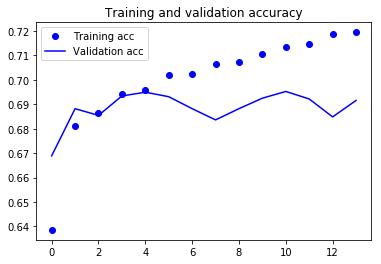

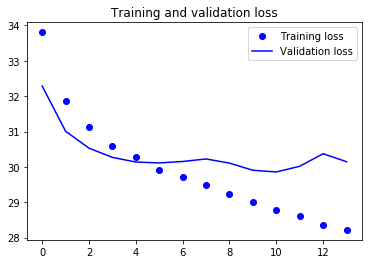

In [7]:
# Basic RNN architecture

clear_session()

def create_rnn_model():
    team_input = layers.Input(shape=(n_time_steps,), dtype='int32', name='team')
    oppo_team_input = layers.Input(shape=(n_time_steps,), dtype='int32', name='oppo_team')
    round_type_input = layers.Input(shape=(n_time_steps,), dtype='int32', name='round_type')
    stats_input = layers.Input(shape=(n_time_steps, n_features - 3), dtype='float32', name='stats')

    team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_time_steps)(team_input)
    oppo_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_time_steps)(oppo_team_input)
    round_type_layer = layers.Embedding(n_round_types * 2, 4, input_length=n_time_steps)(round_type_input)
    
    concated_layers = layers.concatenate([team_layer, oppo_team_layer, round_type_layer, stats_input])
    lstm_1 = layers.LSTM(50, input_shape=(n_time_steps, n_features), return_sequences=False)(concated_layers)
    output = layers.Dense(1)(lstm_1)

    model = models.Model(
        inputs=[
            team_input,
            oppo_team_input,
            round_type_input,
            stats_input
        ],
        outputs=output
    )
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tip_accuracy])

    return model


rnn_pipe = make_pipeline(
    make_union(cat_pipe, num_pipe),
    TimeStepReshaper(n_steps=n_time_steps),
    InputLister(n_inputs=4),
    KerasRegressor(build_fn=create_rnn_model,
                   epochs=20,
                   validation_split=0.2,
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=3)])
)

rnn_pipe.fit(X_train, y_train)

graph_tf_model_history(rnn_pipe.steps[-1][1].model.history)

### One hidden layer overfits

Even though this model only has one LSTM layer, the validation performance starts to deviate from the training performance around epoch 5, indicating serious overfitting.

## RNN with dropout

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib

Train on 13071 samples, validate on 3268 samples
Epoch 1/30
13071/13071 [==============================] - 11s 870us/step - loss: 34.3196 - tip_accuracy: 0.6202 - val_loss: 32.8136 - val_tip_accuracy: 0.6466
Epoch 2/30
13071/13071 [==============================] - 15s 1ms/step - loss: 32.7179 - tip_accuracy: 0.6544 - val_loss: 31.5594 - val_tip_accuracy: 0.6698
Epoch 3/30
13071/13071 [==============================] - 13s 1ms/step - loss: 32.0942 - tip_accuracy: 0.6641 - val_loss: 30.9577 - val_tip_accuracy: 0.6790
Epoch 4/30
13071/13071 [==============================] - 10s 745us/step - loss: 31.6713 - tip_accuracy: 0.6700 - val_loss: 30.8556 - val_tip_accuracy: 0.6821
Epoch 5/30
13071/13071 [==============================] - 10s 778us/step - loss: 31.6207 - tip_accuracy: 0.6677 - val_loss: 30.5957 - val_tip_accuracy: 0.6796
Epoch 6/30
13071/13071 [==============================] - 14s 1ms/step - loss: 31.3282 - tip_accuracy: 0.6727 - val_loss: 30.4274 - val_tip_accuracy: 0.6854
Epo

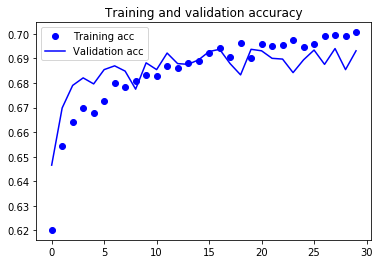

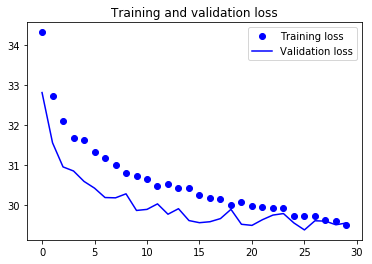

In [11]:
# RNN with some dropout

clear_session()

def create_dropout_rnn_model():
    team_input = layers.Input(shape=(n_time_steps,), dtype='int32', name='team')
    oppo_team_input = layers.Input(shape=(n_time_steps,), dtype='int32', name='oppo_team')
    round_type_input = layers.Input(shape=(n_time_steps,), dtype='int32', name='round_type')
    stats_input = layers.Input(shape=(n_time_steps, n_features - 3), dtype='float32', name='stats')

    team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_time_steps)(team_input)
    oppo_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_time_steps)(oppo_team_input)
    round_type_layer = layers.Embedding(n_round_types * 2, 4, input_length=n_time_steps)(round_type_input)
    
    concated_layers = layers.concatenate([team_layer, oppo_team_layer, round_type_layer, stats_input])

    lstm_1 = layers.LSTM(50, input_shape=(n_time_steps, n_features), return_sequences=False,
                         dropout=0.2, recurrent_dropout=0.5)(concated_layers)
    output = layers.Dense(1)(lstm_1)

    model = models.Model(
        inputs=[
            team_input,
            oppo_team_input,
            round_type_input,
            stats_input
        ],
        outputs=output
    )
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tip_accuracy])

    return model


do_pipe = make_pipeline(
    make_union(cat_pipe, num_pipe),
    TimeStepReshaper(n_steps=n_time_steps),
    InputLister(n_inputs=4),
    KerasRegressor(build_fn=create_dropout_rnn_model,
                   epochs=30,
                   validation_split=0.2,
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)])
)

do_pipe.fit(X_train, y_train)

graph_tf_model_history(do_pipe.steps[-1][1].model.history)

### Adding dropout to the LSTM nearly eliminates overfitting

The accuracy seems to deviate a little after epoch 20 or so, but the validation error is equal to or below the training error through all 30 epochs. Also, the validation error min is around 29.5, whereas the unregularized model's min is around 30.1. We can now start adding layers to try to improve performance.

## Increase # of neurons

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib

Train on 13071 samples, validate on 3268 samples
Epoch 1/40
13071/13071 [==============================] - 11s 829us/step - loss: 33.5749 - tip_accuracy: 0.6299 - val_loss: 31.3331 - val_tip_accuracy: 0.6805
Epoch 2/40
13071/13071 [==============================] - 9s 668us/step - loss: 31.9188 - tip_accuracy: 0.6648 - val_loss: 30.9113 - val_tip_accuracy: 0.6714
Epoch 3/40
13071/13071 [==============================] - 8s 612us/step - loss: 31.3783 - tip_accuracy: 0.6775 - val_loss: 30.3774 - val_tip_accuracy: 0.6903
Epoch 4/40
13071/13071 [==============================] - 9s 653us/step - loss: 31.1640 - tip_accuracy: 0.6724 - val_loss: 30.0445 - val_tip_accuracy: 0.6876
Epoch 5/40
13071/13071 [==============================] - 9s 689us/step - loss: 30.8925 - tip_accuracy: 0.6768 - val_loss: 30.0196 - val_tip_accuracy: 0.6854
Epoch 6/40
13071/13071 [==============================] - 9s 680us/step - loss: 30.7440 - tip_accuracy: 0.6785 - val_loss: 29.9267 - val_tip_accuracy: 0.6931
Ep

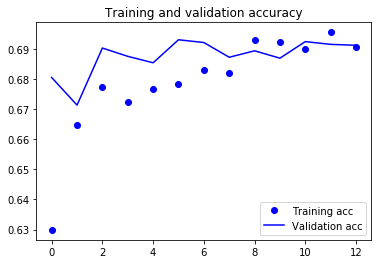

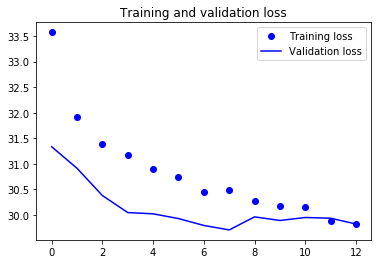

In [30]:
# RNN with some dropout

clear_session()

def create_wide_rnn_model():
    team_input = layers.Input(shape=(n_time_steps,), dtype='int32', name='team')
    oppo_team_input = layers.Input(shape=(n_time_steps,), dtype='int32', name='oppo_team')
    round_type_input = layers.Input(shape=(n_time_steps,), dtype='int32', name='round_type')
    stats_input = layers.Input(shape=(n_time_steps, n_features - 3), dtype='float32', name='stats')

    team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_time_steps)(team_input)
    oppo_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_time_steps)(oppo_team_input)
    round_type_layer = layers.Embedding(n_round_types * 2, 4, input_length=n_time_steps)(round_type_input)
    
    concated_layers = layers.concatenate([team_layer, oppo_team_layer, round_type_layer, stats_input])

    lstm_1 = layers.LSTM(100, input_shape=(n_time_steps, n_features), return_sequences=False,
                         dropout=0.2, recurrent_dropout=0.4)(concated_layers)
    output = layers.Dense(1)(lstm_1)

    model = models.Model(
        inputs=[
            team_input,
            oppo_team_input,
            round_type_input,
            stats_input
        ],
        outputs=output
    )
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tip_accuracy])

    return model


wide_pipe = make_pipeline(
    make_union(cat_pipe, num_pipe),
    TimeStepReshaper(n_steps=n_time_steps),
    InputLister(n_inputs=4),
    KerasRegressor(build_fn=create_wide_rnn_model,
                   epochs=40,
                   validation_split=0.2,
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)])
)

wide_pipe.fit(X_train, y_train)

graph_tf_model_history(wide_pipe.steps[-1][1].model.history)

### Wider cells don't help performance by much

## Add another LSTM layer

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib

Train on 13071 samples, validate on 3268 samples
Epoch 1/40
13071/13071 [==============================] - 29s 2ms/step - loss: 33.4488 - tip_accuracy: 0.6349 - val_loss: 31.4527 - val_tip_accuracy: 0.6671
Epoch 2/40
13071/13071 [==============================] - 21s 2ms/step - loss: 32.1150 - tip_accuracy: 0.6600 - val_loss: 30.6002 - val_tip_accuracy: 0.6885
Epoch 3/40
13071/13071 [==============================] - 21s 2ms/step - loss: 31.6231 - tip_accuracy: 0.6708 - val_loss: 30.2996 - val_tip_accuracy: 0.6940
Epoch 4/40
13071/13071 [==============================] - 20s 2ms/step - loss: 31.3648 - tip_accuracy: 0.6692 - val_loss: 29.9947 - val_tip_accuracy: 0.6851
Epoch 5/40
13071/13071 [==============================] - 24s 2ms/step - loss: 31.2180 - tip_accuracy: 0.6759 - val_loss: 29.9360 - val_tip_accuracy: 0.6916
Epoch 6/40
13071/13071 [==============================] - 27s 2ms/step - loss: 30.9716 - tip_accuracy: 0.6805 - val_loss: 29.8481 - val_tip_accuracy: 0.6943
Epoch 7/4

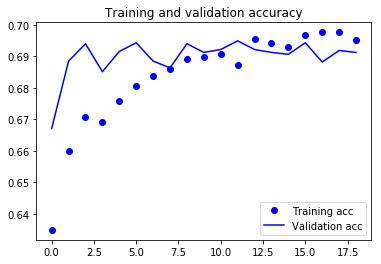

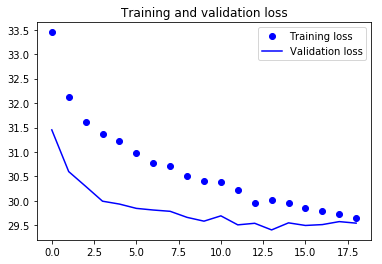

In [27]:
# RNN with some dropout

clear_session()

def create_deep_rnn_model():
    team_input = layers.Input(shape=(n_time_steps,), dtype='int32', name='team')
    oppo_team_input = layers.Input(shape=(n_time_steps,), dtype='int32', name='oppo_team')
    round_type_input = layers.Input(shape=(n_time_steps,), dtype='int32', name='round_type')
    stats_input = layers.Input(shape=(n_time_steps, n_features - 3), dtype='float32', name='stats')

    team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_time_steps)(team_input)
    oppo_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_time_steps)(oppo_team_input)
    round_type_layer = layers.Embedding(n_round_types * 2, 4, input_length=n_time_steps)(round_type_input)
    
    concated_layers = layers.concatenate([team_layer, oppo_team_layer, round_type_layer, stats_input])

    lstm_1 = layers.LSTM(100, input_shape=(n_time_steps, n_features), return_sequences=True,
                         dropout=0.3, recurrent_dropout=0.6)(concated_layers)
    lstm_2 = layers.LSTM(100, input_shape=(n_time_steps, n_features), return_sequences=False,
                         dropout=0.3, recurrent_dropout=0.6)(lstm_1)
    output = layers.Dense(1)(lstm_2)

    model = models.Model(
        inputs=[
            team_input,
            oppo_team_input,
            round_type_input,
            stats_input
        ],
        outputs=output
    )
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tip_accuracy])

    return model


deep_pipe = make_pipeline(
    make_union(cat_pipe, num_pipe),
    TimeStepReshaper(n_steps=n_time_steps),
    InputLister(n_inputs=4),
    KerasRegressor(build_fn=create_deep_rnn_model,
                   epochs=40,
                   validation_split=0.2,
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)])
)

deep_pipe.fit(X_train, y_train)

graph_tf_model_history(deep_pipe.steps[-1][1].model.history)

### A second hidden layer adds stability to per-epoch performance
Although it doesn't improve the best score by much, if at all, adding a second layer and adjusting the regularization accordingly causes the error and accuracy to bounce around less as the model trains. This should make model performance more consistent.

## Yearly Performance: RNN vs CNN

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: 'team' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/s

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: 'team' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: 'team' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


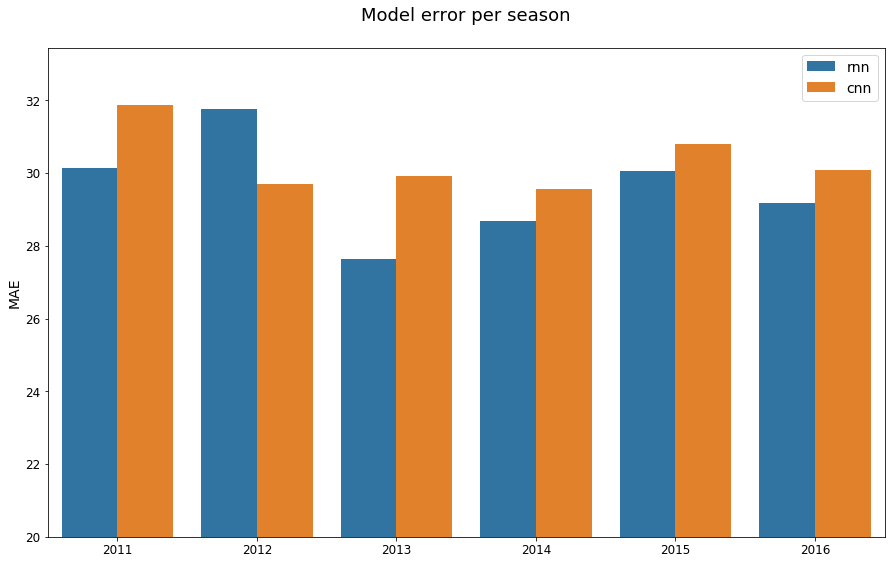

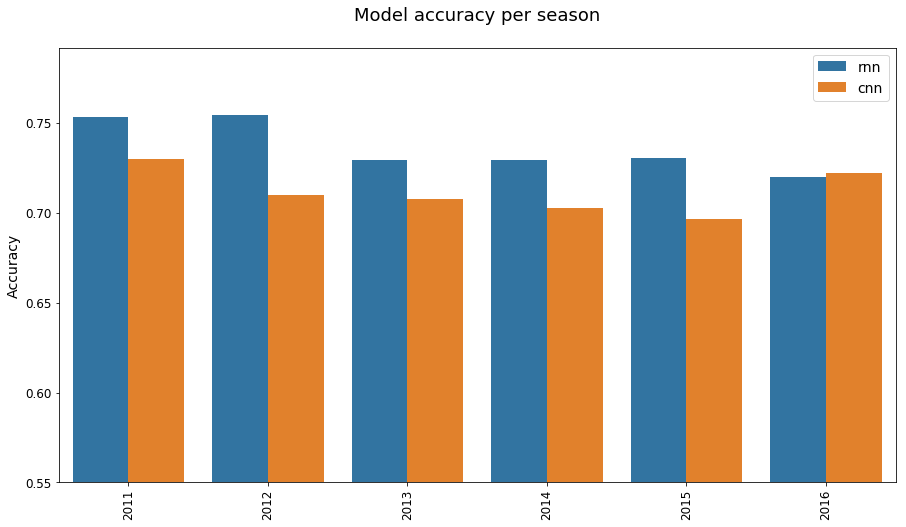

,model,year,error,accuracy
0,rnn,2011,30.151172,0.753247
1,cnn,2011,31.857283,0.729870
2,rnn,2012,31.770271,0.754300
3,cnn,2012,29.694984,0.710074
4,rnn,2013,27.638460,0.729469
5,cnn,2013,29.916139,0.707729
6,rnn,2014,28.688711,0.729469
7,cnn,2014,29.558300,0.702899
8,rnn,2015,30.066298,0.730583
9,cnn,2015,30.802007,0.696602


In [37]:
def yearly_performance_scores(estimators, features, labels):
    model_names = []
    errors = []
    accuracies = []
    years = []

    for year in range(2011, 2017):
        feat_train = features[features['year'] < year]
        # Need to add n_time_steps rows from previous season for test set to not lose test data when shifting
        # to add time steps to data
        feat_pre_test_groups = features[features['year'] == year - 1].groupby('team')
        shifted_groups = [group.shift(len(group) - n_time_steps).dropna()
                          for _, group in feat_pre_test_groups]
        feat_test = pd.concat([features[features['year'] == year]] + shifted_groups, sort=False).sort_index()
        X_train = feat_train.values
        X_test = feat_test.values

        lab_train = labels.loc[feat_train.index]
        lab_test = labels.loc[feat_test.index]
        y_train = label_reshaper.transform(lab_train.values)[:, 0, :]
        y_test = label_reshaper.transform(lab_test.values)[:, 0, :]

        for estimator_name, estimator in estimators:
            estimator.fit(X_train, y_train, kerasregressor__verbose=0)
            
            y_pred = estimator.predict(X_test).reshape((-1, 1))

            years.append(year)
            model_names.append(estimator_name)
            errors.append(mean_absolute_error(y_test, y_pred))
            accuracies.append(regression_accuracy(y_test, y_pred))

    year_scores = pd.DataFrame({'model': model_names,
                                'year': years,
                                'error': errors,
                                'accuracy': accuracies}).astype({'year': int})
    
    return year_scores

# Compare to best-performing CNN from notebook 6.0
def create_cnn_model():
    team_input = layers.Input(shape=(n_time_steps,), dtype='int32', name='team')
    oppo_team_input = layers.Input(shape=(n_time_steps,), dtype='int32', name='oppo_team')
    round_type_input = layers.Input(shape=(n_time_steps,), dtype='int32', name='round_type')
    stats_input = layers.Input(shape=(n_time_steps, n_features - 3), dtype='float32', name='stats')

    team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_time_steps)(team_input)
    oppo_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_time_steps)(oppo_team_input)
    round_type_layer = layers.Embedding(n_round_types * 2, 4, input_length=n_time_steps)(round_type_input)
    
    concated_layers = layers.concatenate([team_layer, oppo_team_layer, round_type_layer, stats_input])

    conv_layer_1 = layers.Conv1D(32, 2, activation='relu')(concated_layers)
    pool_layer_1 = layers.MaxPooling1D(2)(conv_layer_1)
    conv_layer_2 = layers.Conv1D(32, 2, activation='relu')(pool_layer_1)
    pool_layer_2 = layers.GlobalMaxPooling1D()(conv_layer_2)
    dropout_layer_1 = layers.Dropout(0.5)(pool_layer_2)
    output = layers.Dense(1, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(dropout_layer_1)

    model = models.Model(
        inputs=[
            team_input,
            oppo_team_input,
            round_type_input,
            stats_input
        ],
        outputs=output
    )
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tip_accuracy])

    return model

final_rnn_pipe = make_pipeline(
    make_union(cat_pipe, num_pipe),
    TimeStepReshaper(n_steps=n_time_steps),
    InputLister(n_inputs=4),
    KerasRegressor(build_fn=create_deep_rnn_model,
                   epochs=40,
                   validation_split=0.2,
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=3)])
)
final_cnn_pipe = make_pipeline(
    make_union(cat_pipe, num_pipe),
    TimeStepReshaper(n_steps=n_time_steps),
    InputLister(n_inputs=4),
    KerasRegressor(build_fn=create_cnn_model,
                   epochs=20,
                   validation_split=0.2,
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=3)])
)

estimators = [('rnn', final_rnn_pipe), ('cnn', final_cnn_pipe)]
est_year_scores = yearly_performance_scores(estimators, features, labels)

graph_yearly_model_performance(est_year_scores)

est_year_scores

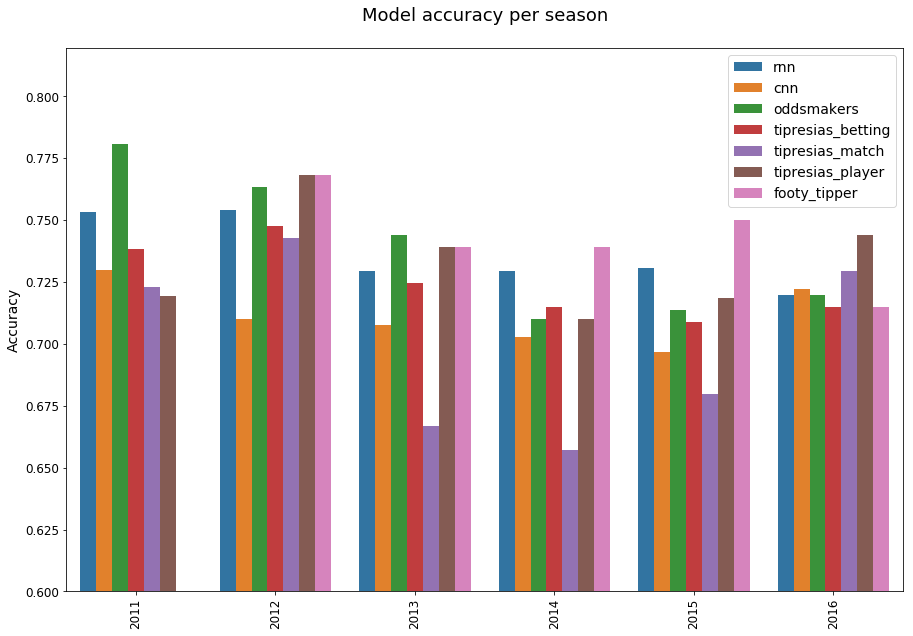

In [38]:
prediction_df = pd.read_csv('../data/model_predictions.csv')
prediction_scores = (prediction_df
                     .groupby(['model', 'year'])
                     .mean()['tip_point']
                     .reset_index()
                     .rename(columns={'tip_point': 'accuracy'}))
# Footy tipper accuracy scores taken from a trial that took too long to run,
# so I'm just copy pasting from a notebook
footy_tipper_scores = pd.DataFrame({'model': ['footy_tipper'] * len(range(2012, 2017)),
                                    'year': list(range(2012, 2017)),
                                    'error': [0] * len(range(2012, 2017)),
                                    'accuracy': [0.768116, 0.739130, 0.739130, 0.750000, 0.714976]})

all_year_scores = (pd
                   .concat([est_year_scores, prediction_scores, footy_tipper_scores],
                           sort=True)
                   .reset_index(drop=True))

# Accuracy scores
plt.figure(figsize=(15, 10))
sns.barplot(x='year', y='accuracy', hue='model', data=all_year_scores[all_year_scores['year'] > 2010])
# Not starting axis at 0 to make small relative differences clearer
plt.ylim(bottom=0.6)
plt.title('Model accuracy per season\n', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

### RNN performs better than CNN
It might not be worth the extra training time (RNN takes 7-8 secs per epoch; CNN takes 2-3 secs), but RNN is decidedly better than CNN in terms of both error and accuracy, so I'll use that for now.